In [ ]:
import numpy as np
import pandas as pd
import os
from os import listdir
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB3

In [ ]:
EPOCHS = 10
INIT_LR = 0.001
BS = 32
image_size = 0
directory_root = '/content/drive/MyDrive/Crop Disease/Image Data base'
width=200
height=200
depth=1
img_size = (200,200)

In [ ]:
image_list, label_list,training_data,image_path = [], [],[],[]
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    dir = ''
    for plant_folder in root_dir :

        if plant_folder != 'Healthy':
          plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
          print(f"[INFO] Processing {plant_folder} ...")

          if len(plant_disease_folder_list) >= 200:
            for image in plant_disease_folder_list[:300]:

                image_directory = f'{directory_root}/{plant_folder}/{image}'
              
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                          image_list.append(convert_image_to_array(image_directory))
                          label_list.append(plant_folder)
                          image_path.append(image_directory)
        

    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing algal leaf in tea ...
[INFO] Processing anthracnose in tea ...
[INFO] Processing Apple Apple scab ...
[INFO] Processing Apple Black rot ...
[INFO] Processing Apple Cedar apple rust ...
[INFO] Processing Bacterial leaf blight in rice leaf ...
[INFO] Processing bird eye spot in tea ...
[INFO] Processing Blight in corn Leaf ...
[INFO] Processing brown blight in tea ...
[INFO] Processing Brown spot in rice leaf ...
[INFO] Processing cabbage looper ...
[INFO] Processing Cercospora leaf spot ...
[INFO] Processing Cherry (including sour) Powdery mildew ...
[INFO] Processing Common Rust in corn Leaf ...
[INFO] Processing Grape Black rot ...
[INFO] Processing Gray Leaf Spot in corn Leaf ...
[INFO] Processing lemon canker ...
[INFO] Processing Nitrogen deficiency in plant ...
[INFO] Processing potassium deficiency in plant ...
[INFO] Processing Potato Early blight ...
[INFO] Processing Potato Late blight ...
[INFO] Processing Sogatella rice ...
[INFO] 

In [ ]:
plant_folder = 'Healthy'
plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")

  
for h_folder in plant_disease_folder_list:

  h_dir = listdir(f'{directory_root}/{plant_folder}/{h_folder}')

  for image in h_dir[:300]:

    image_directory = f'{directory_root}/{plant_folder}/{h_folder}/{image}'
  
    if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
              image_list.append(convert_image_to_array(image_directory))
              label_list.append(plant_folder)
              image_path.append(image_directory)

In [ ]:
Fseries=pd.Series(image_path, name='filepaths')
Lseries=pd.Series(label_list, name='labels')        
df=pd.concat([Fseries, Lseries], axis=1)


In [ ]:
df

,filepaths,labels
0,/content/drive/MyDrive/Crop Disease/Image Data...,algal leaf in tea
1,/content/drive/MyDrive/Crop Disease/Image Data...,algal leaf in tea
2,/content/drive/MyDrive/Crop Disease/Image Data...,algal leaf in tea
3,/content/drive/MyDrive/Crop Disease/Image Data...,algal leaf in tea
4,/content/drive/MyDrive/Crop Disease/Image Data...,algal leaf in tea
...,...,...
6229,/content/drive/MyDrive/Crop Disease/Image Data...,Healthy
6230,/content/drive/MyDrive/Crop Disease/Image Data...,Healthy
6231,/content/drive/MyDrive/Crop Disease/Image Data...,Healthy
6232,/content/drive/MyDrive/Crop Disease/Image Data...,Healthy


In [ ]:
train_df, dummy_df=train_test_split(df, train_size=.9, shuffle=True, random_state=123, stratify=df['labels'])
valid_df, test_df=train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['labels'])


In [ ]:
batch_size=20 # We will use and EfficientetB3 model, with image size of (200, 250) this size should not cause resource error
trgen=ImageDataGenerator(horizontal_flip=True,rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2 )
t_and_v_gen=ImageDataGenerator()
msg='{0:70s} for train generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
msg='{0:70s} for valid generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
# for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
# this insures that we go through all the sample in the test set exactly once.
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
msg='{0:70s} for test generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
# from the generator we can get information we will need later
classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)

Found 5610 validated image filenames belonging to 21 classes.
Found 312 validated image filenames belonging to 21 classes.
Found 312 validated image filenames belonging to 21 classes.
test batch size:  78   test steps:  4  number of classes :  21


In [ ]:
class_count = 21

# EfficientNet Model Loading and Fine Tuning

In [ ]:
img_shape=(height,width, 3)
from tensorflow.keras.applications import EfficientNetB3
base_model=EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
base_model.trainable=True

43941136/43941136 [==============================] - 2s 0us/step


In [ ]:
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)       
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)

# Model Compilation
lr=.001 # start with this learning rate
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 

# Model Training
epochs=10
ask_epoch=5
ask=LR_ASK(model, epochs,  ask_epoch)
callbacks=[ask]

history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

In [ ]:
pip install visualkeras


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 32.7 MB/s eta 0:00:00


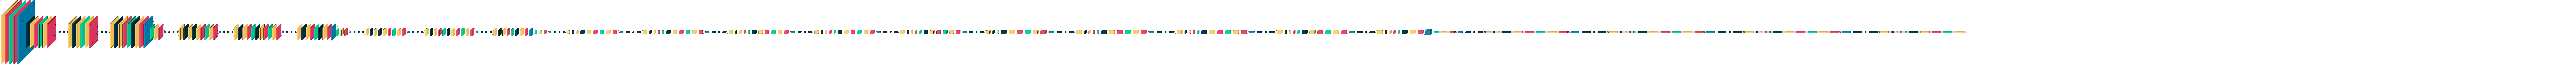

In [ ]:
import visualkeras
from PIL import ImageFont

visualkeras.layered_view(model,legend=False,spacing=50) 


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 200, 200, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 200, 200, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                            

In [ ]:
class LR_ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch): # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1
        
        
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            print('Training will proceed until epoch', ask_epoch,' then you will be asked to') 
            print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')  
        self.start_time= time.time() # set the time at which training started
        
    def on_train_end(self, logs=None):   # runs at the end of training  
        print('loading model with weights from epoch ', self.best_epoch)
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        if v_loss< self.lowest_vloss:
            self.lowest_vloss=v_loss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1
            print (f'\n validation loss of {v_loss:7.4f} is below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights')
        else:
            print (f'\n validation loss of {v_loss:7.4f} is above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights')
        
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                print('\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)
                        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                        print(f'current LR is  {lr:7.5f}  hit enter to keep  this LR or enter a new LR')
                        ans=input(' ')
                        if ans =='':
                            print (f'keeping current LR of {lr:7.5f}')
                        else:
                            new_lr=float(ans)
                            tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                            print(' changing LR to ', ans)

In [ ]:
epochs=10
ask_epoch=5
ask=LR_ASK(model, epochs,  ask_epoch)
callbacks=[ask]

history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)


Training will proceed until epoch 5  then you will be asked to
 enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/10
281/281 [==============================] - ETA: 0s - loss: 7.3201 - accuracy: 0.7168 
 validation loss of  5.3669 is below lowest loss, saving weights from epoch 1   as best weights
281/281 [==============================] - 3314s 12s/step - loss: 7.3201 - accuracy: 0.7168 - val_loss: 5.3669 - val_accuracy: 0.9231
Epoch 2/10
281/281 [==============================] - ETA: 0s - loss: 4.2812 - accuracy: 0.9169 
 validation loss of  3.2439 is below lowest loss, saving weights from epoch 2   as best weights
281/281 [==============================] - 3203s 11s/step - loss: 4.2812 - accuracy: 0.9169 - val_loss: 3.2439 - val_accuracy: 0.9391
Epoch 3/10
281/281 [==============================] - ETA: 0s - loss: 2.5685 - accuracy: 0.9501 
 validation loss of  1.8781 is below lowest loss, saving weights from epoch 3   as best 

UnknownError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    
tr_plot(history,0)

In [ ]:
def predictor(test_gen, test_steps):
    y_pred= []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)    
    for i, p in enumerate(preds):        
        pred_index=np.argmax(p)         
        true_index=test_gen.labels[i]  # labels are integer values        
        if pred_index != true_index: # a misclassification has occurred                                           
            errors=errors + 1
        y_pred.append(pred_index)
            
    acc=( 1-errors/tests) * 100 
    print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests
errors, tests=predictor(test_gen, test_steps)